### RNN with A Single Neuron

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

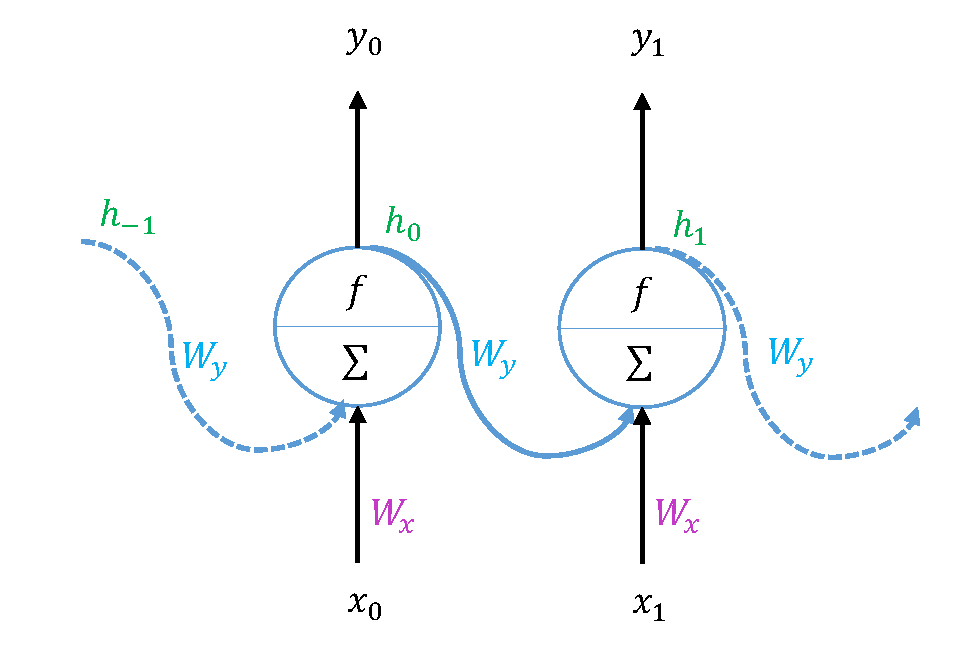

In [2]:
class SingleRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(SingleRNN, self).__init__()

        self.Wx = torch.randn(n_inputs, n_neurons)  # 4 X 1
        self.Wy = torch.randn(n_neurons, n_neurons)  # 1 X 1

        self.b = torch.zeros(1, n_neurons)  # 1 X 4

    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b)  # 4 X 1

        self.Y1 = torch.tanh(
            torch.mm(self.Y0, self.Wy) + torch.mm(X1, self.Wx) + self.b
        )  # 4 X 1

        return self.Y0, self.Y1

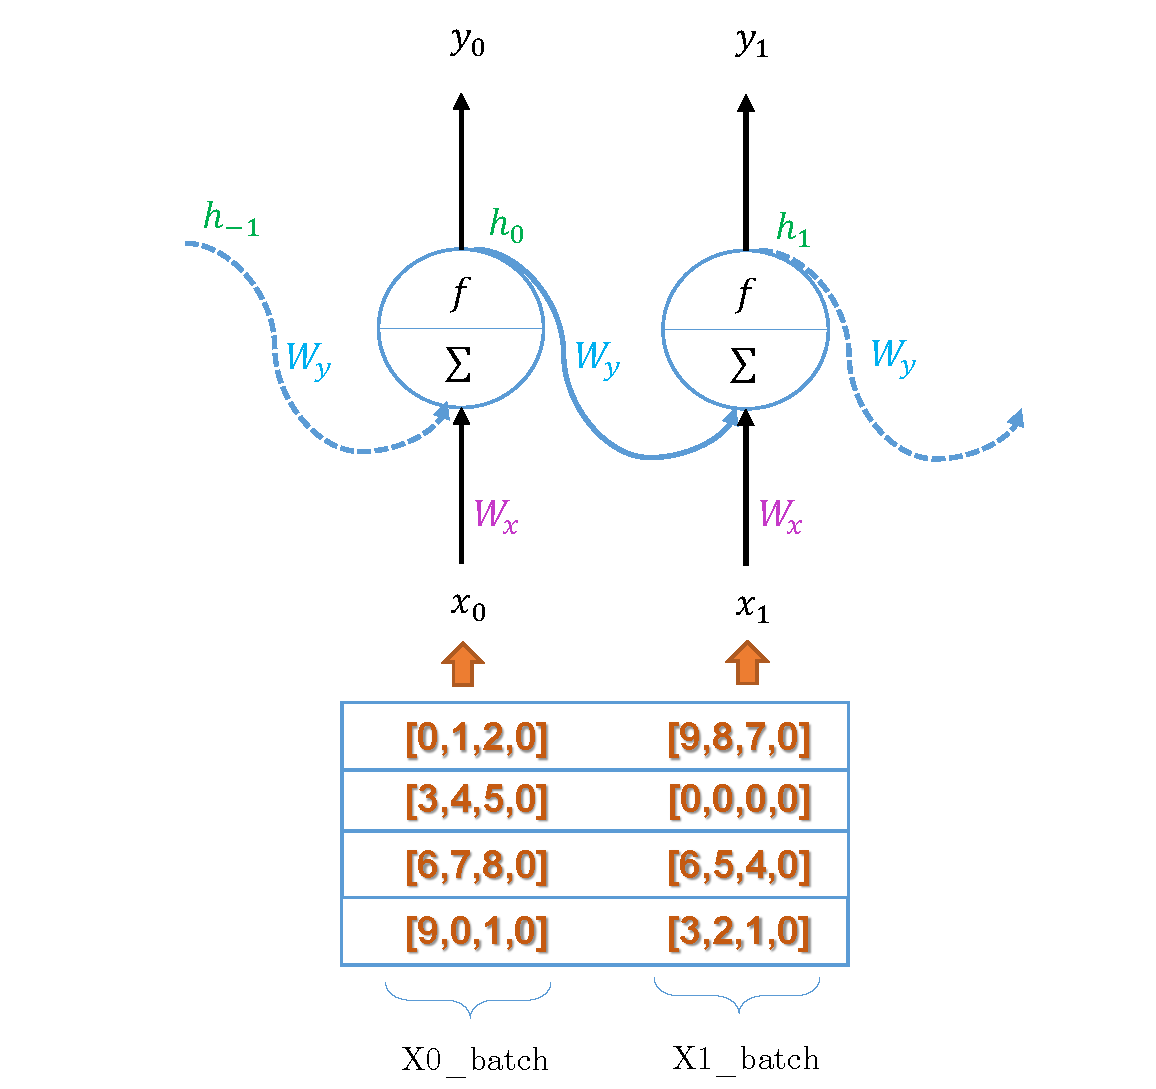

In [3]:
N_INPUT = 4
N_NEURONS = 1

X0_batch = torch.tensor(
    [[0, 1, 2, 0], [3, 4, 5, 0], [6, 7, 8, 0]], dtype=torch.float
)  # t=0 => 3 X 4

X1_batch = torch.tensor(
    [[9, 8, 7, 0], [0, 0, 0, 0], [6, 5, 4, 0]], dtype=torch.float
)  # t=1 => 3 X 4

model = SingleRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

In [4]:
X0_batch.shape

torch.Size([3, 4])

In [5]:
Y0_val, Y1_val  # Y_0 at t=0, Y_1: at t=1

(tensor([[-0.3367],
         [ 0.4504],
         [ 0.8670]]),
 tensor([[ 0.9958],
         [-0.2935],
         [ 0.8936]]))

### Increasing Neurons in RNN Layer

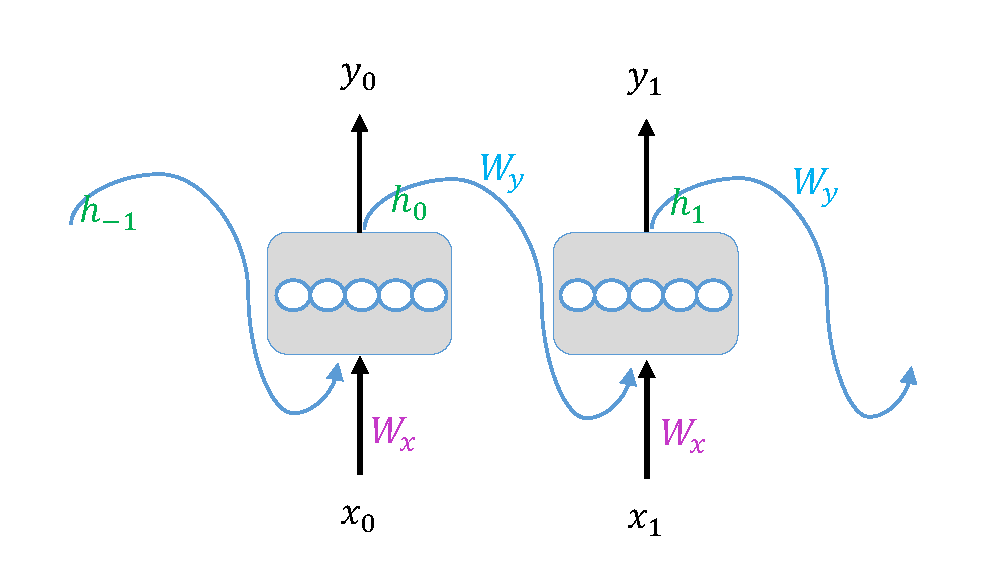

In [6]:
class BasicRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(SingleRNN, self).__init__()

        self.Wx = torch.randn(n_inputs, n_neurons)  # n_inputs X n_neurons
        self.Wy = torch.randn(n_neurons, n_neurons)  # n_neurons X n_neurons

        self.b = torch.zeros(1, n_neurons)  # 1 X n_neurons

    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b)  # batch_size X n_neurons

        self.Y1 = torch.tanh(
            torch.mm(self.Y0, self.Wy) + torch.mm(X1, self.Wx) + self.b
        )  # batch_size X n_neurons

        return self.Y0, self.Y1

In [7]:
N_INPUT = 3  # number of features in input
N_NEURONS = 5  # number of units in layer

X0_batch = torch.tensor(
    [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]], dtype=torch.float
)  # t=0 => 4 X 3

X1_batch = torch.tensor(
    [[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]], dtype=torch.float
)  # t=1 => 4 X 3

model = SingleRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

In [8]:
Y0_val, Y1_val  # Y_0 at t=0, Y_1: at t=1

(tensor([[-0.4744,  0.9274, -0.9103,  0.2371, -0.9988],
         [-0.8609,  1.0000, -1.0000,  0.1058, -1.0000],
         [-0.9691,  1.0000, -1.0000, -0.0292, -1.0000],
         [-1.0000,  1.0000, -1.0000,  0.7479, -1.0000]]),
 tensor([[-0.8228,  1.0000, -1.0000,  0.0833, -1.0000],
         [ 0.8576, -0.3851, -0.8409,  0.7464, -0.8881],
         [ 0.4136,  1.0000, -1.0000,  0.3936, -1.0000],
         [ 0.5737,  1.0000, -1.0000,  0.7924, -1.0000]]))

In [9]:
Y0_val.shape

torch.Size([4, 5])

### PyTorch Built-in RNN Cell

In [10]:
rnn = nn.RNNCell(3, 5)  # n_input X n_neurons

X_batch = torch.tensor(
    [
        [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]],
        [[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]],
    ],
    dtype=torch.float,
)  # X0 and X1

hx = torch.randn(4, 5)  # batch_size X n_neurons
output = []

# for each time step
for i in range(2):
    hx = rnn(X_batch[i], hx)
    output.append(hx)

print(output)  # Y_0, Y_1
print(output[0].size())

[tensor([[ 0.2762, -0.3525, -0.5195, -0.6904,  0.4060],
        [ 0.9824,  0.1890, -0.9075, -0.9649,  0.3978],
        [ 0.9981, -0.0798, -0.9840, -0.9353,  0.9865],
        [-0.9987,  0.9694,  0.0201, -0.9940,  0.9982]], grad_fn=<TanhBackward>), tensor([[ 0.9713,  0.8566, -0.9937, -0.9826,  0.9998],
        [-0.6298,  0.2680, -0.2933, -0.5841,  0.3070],
        [ 0.6736,  0.8230, -0.9661, -0.9360,  0.9971],
        [-0.8314,  0.6027, -0.7352, -0.7050,  0.9937]], grad_fn=<TanhBackward>)]
torch.Size([4, 5])


##### Let's formally build the computation graph using the same information we used above

In [11]:
class CleanBasicRNN(nn.Module):
    def __init__(self, batch_size, n_inputs, n_neurons):
        super(CleanBasicRNN, self).__init__()

        self.rnn = nn.RNNCell(n_inputs, n_neurons)
        self.hx = torch.randn(batch_size, n_neurons)  # initialize hidden state

    def forward(self, X):
        output = []

        # for each time step
        for i in range(2):
            self.hx = self.rnn(X[i], self.hx)
            output.append(self.hx)

        return output, self.hx


FIXED_BATCH_SIZE = 4  # our batch size is fixed for now
N_INPUT = 3
N_NEURONS = 5

X_batch = torch.tensor(
    [
        [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]],
        [[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]],
    ],
    dtype=torch.float,
)  # X0 and X1


model = CleanBasicRNN(FIXED_BATCH_SIZE, N_INPUT, N_NEURONS)
output_val, states_val = model(X_batch)
print(output_val)  # contains all output for all timesteps
print(states_val)  # contains values for final state or final timestep, i.e., t=1

[tensor([[ 0.5206,  0.2722, -0.5245,  0.6018, -0.6431],
        [-0.8109,  0.9534, -0.9971,  0.9994, -0.9948],
        [-0.9857,  0.9964, -0.9991,  1.0000, -0.9975],
        [-0.8987,  0.9964,  0.6505,  0.9996,  0.5456]], grad_fn=<TanhBackward>), tensor([[-0.9994,  0.9996, -0.9987,  1.0000, -0.9991],
        [-0.5743,  0.3052, -0.3161,  0.3875,  0.0432],
        [-0.9975,  0.9921, -0.9891,  0.9999, -0.9711],
        [-0.8247,  0.9369,  0.1413,  0.9689, -0.2522]], grad_fn=<TanhBackward>)]
tensor([[-0.9994,  0.9996, -0.9987,  1.0000, -0.9991],
        [-0.5743,  0.3052, -0.3161,  0.3875,  0.0432],
        [-0.9975,  0.9921, -0.9891,  0.9999, -0.9711],
        [-0.8247,  0.9369,  0.1413,  0.9689, -0.2522]], grad_fn=<TanhBackward>)


In [12]:
len(output_val)  # y_0, y_1

2

In [13]:
output_val[0].shape

torch.Size([4, 5])

## RNN for Image Classification

We will also be using the `RNN` module instead of the `RNNCell` module since we want to generalize the computation graph to be able to support an n number of layers as well. We will only use one layer in the following computation graph, but you can experiment with the code later on by adding more layers.

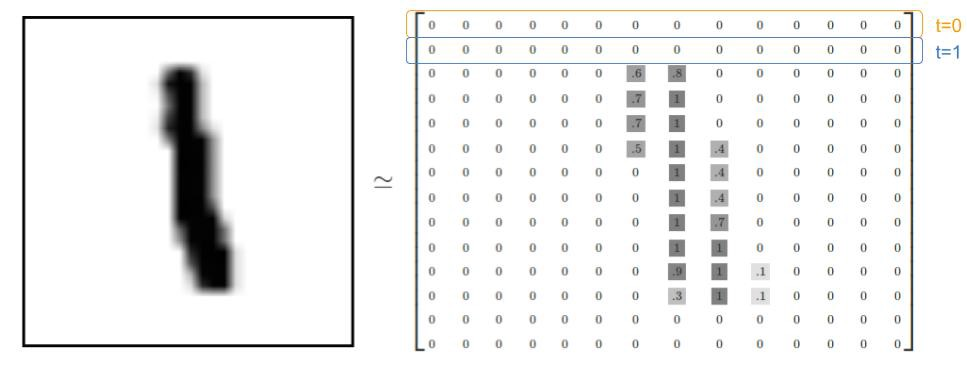

### Importing the dataset

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose([transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

# download and load testing dataset
testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

### Exploring the dataset

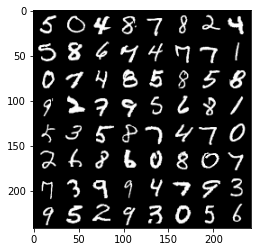

In [15]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
# functions to show an image
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [16]:
images.size()

torch.Size([64, 1, 28, 28])

### Modeling

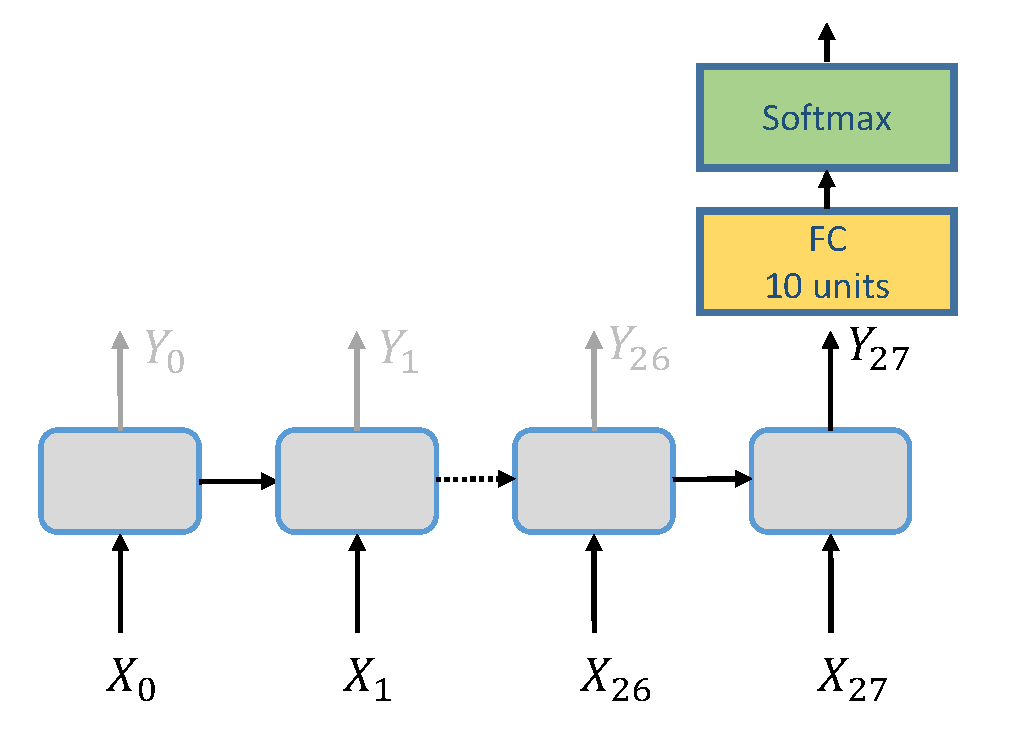

In [17]:
# parameters
N_LAYERS = 2
N_STEPS = 28  # 28 columns
N_INPUTS = 28  # 28 features
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

https://pytorch.org/docs/stable/nn.html#rnn

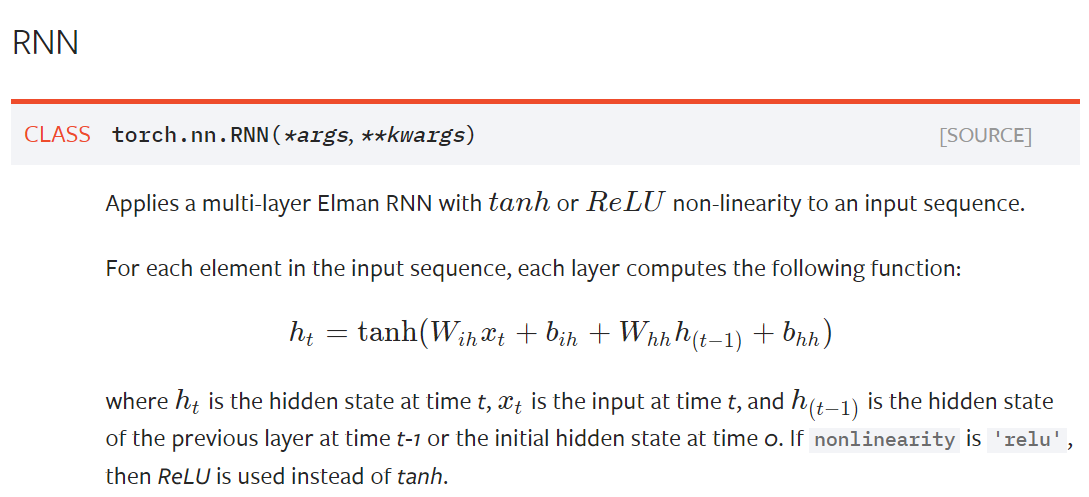

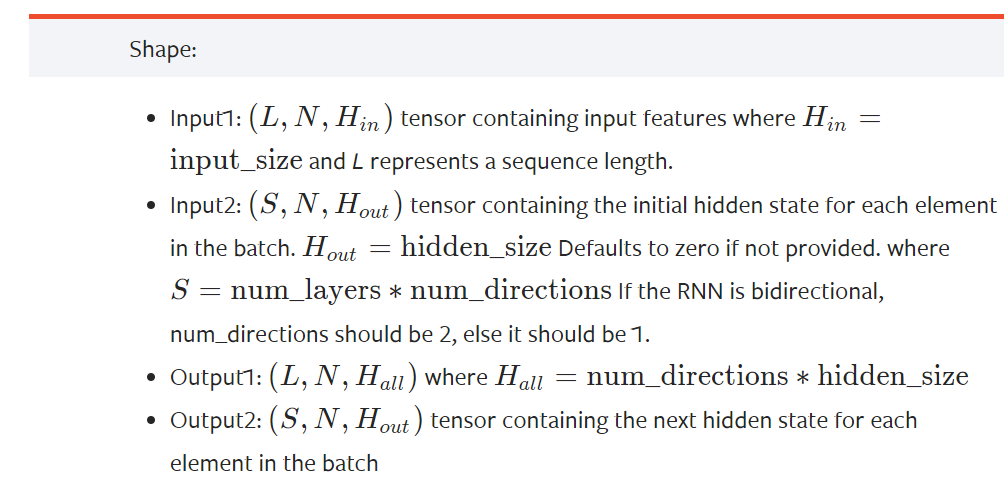

In [18]:
rnn = nn.RNN(10, 20, 2)
ins = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(ins, h0)

In [19]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs, n_layers):
        super(ImageRNN, self).__init__()

        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers

        self.basic_rnn = nn.RNN(
            input_size=self.n_inputs,
            hidden_size=self.n_neurons,
            num_layers=self.n_layers,
        )

        self.FC = nn.Linear(self.n_neurons, self.n_outputs)

    def init_hidden(
        self,
    ):
        # (num_layers, batch_size, n_neurons)
        return torch.zeros(self.n_layers * 1, self.batch_size, self.n_neurons)

    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs (28 timestamps, each t: 64 instances, each insante: 28 features)
        X = X.permute(1, 0, 2)
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()

        rnn_out, self.hidden = self.basic_rnn(X, self.hidden)
        #         print(self.hidden.shape)
        out = self.FC(
            self.hidden.view(self.n_layers, 1, self.batch_size, self.n_neurons)[
                self.n_layers - 1, ...
            ]
        )  # hidden state of all layers neurons at t=last_time_step (t=seq_len)
        #         print(out.shape, out.view(-1, self.n_outputs).shape )
        return out.view(-1, self.n_outputs)  # batch_size X n_output

The `ImageRNN` model is doing the following:
* The initialization function `__init__(...)` declares a few variables, and then a basic RNN layer `basic_rnn` followed by a fully-connected layer `self.FC`.
* The `init_hidden` function initializes hidden weights with zero values. The forward function accepts an input of size `n_steps X batch_size X n_neurons`. The data flows through the RNN layer and then through the fully-connected layer.
* The output represent the log probabilities of the model.

### Testing the model with some samples
A very good practice encouraged by PyTorch developers throughout their documentation, and which I really like and highly recommend, is to always test the model with a portion of the dataset before actual training. This is to ensure that you have the correct dimensions specified and that the model is producing the information you expect. Below I show an example of how to test the model:

In [20]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS, N_LAYERS)
logits = model(images.view(-1, 28, 28))
logits.shape

torch.Size([64, 10])

### Training

In [21]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS, N_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def get_accuracy(logit, target, batch_size):
    """Obtain accuracy for training round"""
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / batch_size
    return accuracy.item()

Before training a model in PyTorch, we can programatically specify what device we want to use during training; the `torch.device` function tells the program that we want to use the GPU if one is available, otherwise the CPU will be the default device.

Then we create an instance of the model, `ImageRNN`, with the proper parameters. The criterion represents the function we will use to compute the loss of the model. The `nn.CrossEntropyLoss()` function basically applies a log softmax followed by a negative log likelihood loss operation over the output of the model. To compute the loss, the function needs both the log probabilities and targets. We will see later in our code how to provide this to the criterion.

For training, we also need an optimization algorithm which helps to update weights based on the current loss. This is achieved with the `optim.Adam` optimization function, which requires the model parameters and a learning rate. Alternatively, we can also use `optim.SGD` or any other optimization algorithm that's available.

The `get_accuracy` function simply computes the accuracy of the model given the log probabilities and target values. Let's put everything together and train our image classification model:

In [22]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()

    # TRAINING ROUND
    for i, data in enumerate(trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # reset hidden states
        model.hidden = model.init_hidden()

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28, 28)

        # forward + backward + optimize
        outputs = model(inputs)

        #         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)

    model.eval()
    print(
        "Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f"
        % (epoch, train_running_loss / i, train_acc / i)
    )

Epoch:  0 | Loss: 0.5940 | Train Accuracy: 80.85
Epoch:  1 | Loss: 0.2714 | Train Accuracy: 92.11
Epoch:  2 | Loss: 0.1917 | Train Accuracy: 94.40
Epoch:  3 | Loss: 0.1721 | Train Accuracy: 95.02
Epoch:  4 | Loss: 0.1424 | Train Accuracy: 95.88
Epoch:  5 | Loss: 0.1410 | Train Accuracy: 96.06
Epoch:  6 | Loss: 0.1400 | Train Accuracy: 96.05
Epoch:  7 | Loss: 0.1173 | Train Accuracy: 96.75
Epoch:  8 | Loss: 0.1140 | Train Accuracy: 96.78
Epoch:  9 | Loss: 0.1115 | Train Accuracy: 96.92


In [23]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print("Test Accuracy: %.2f" % (test_acc / i))

Test Accuracy: 96.42
